**IMPORTING LIBRARIES** 

In [2]:
import os
import shutil
import random #for random distribution of data
from shutil import copyfile
from os import getcwd  # getcwd returns current working directory
import pandas as pd # for data manipulation
import numpy as np # for operation
import tensorflow as tf
from tensorflow.keras.preprocessing import image # for image processing
import matplotlib.pyplot as plt
from keras.utils import np_utils
import cv2
from google.colab.patches import cv2_imshow
from scipy import stats
from PIL import Image
import math
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import dlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive    # for importing dataset from google drive
drive.mount('/content/drive')

In [3]:
from zipfile import ZipFile              # for importing dataset locally from the colab
file_name = '/content/datasets.zip'        
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [4]:
SOURCE = '/content/datasets/CK+48/'     #source directory for images

In [5]:
os.listdir(SOURCE)            # subdirectories of source directory

['disgust', 'contempt', 'surprise', 'fear', 'happy', 'anger', 'sadness']

**PREPROCESSING**

In [6]:

def HistEqualization(image, number_bins = 256):         #implementing the histogram equalization
  # get the image histogram
  image_Hist, bins = np.histogram(image.flatten(), number_bins, [0, 256])
  cdf = image_Hist.cumsum() # cumulative distribution function
  cdf = image_Hist.max()*cdf/cdf.max()  #normalize
  cdf_mask = np.ma.masked_equal(cdf, 0)
  cdf_mask = (cdf_mask - cdf_mask.min())*255/(cdf_mask.max()-cdf_mask.min())
  cdf = np.ma.filled(cdf_mask,0).astype('uint8')
  return cdf[image.astype('uint8')]

In [7]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 "shape_predictor_68_face_landmarks.dat.bz2"

--2020-07-12 10:57:22--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  19.3MB/s    in 3.2s    

2020-07-12 10:57:25 (19.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [8]:

predictor_path = 'shape_predictor_68_face_landmarks.dat'  # path of data

#initializes dlib’s pre-trained face detector based on a modification to the standard Histogram of Oriented Gradients + Linear SVM method for object detection.
detector = dlib.get_frontal_face_detector() 
#loads the facial landmark predictor using the path
predictor = dlib.shape_predictor(predictor_path)

In [9]:
# take a bounding predicted by dlib and convert it
def rect_to_bb(rect):
	
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x1 = rect.left()
	y1 = rect.top()
	w1 = rect.right() - x1
	h1 = rect.bottom() - y1

	# return a tuple of (x, y, w, h)
	return (x1, y1, w1, h1)
 
# extract 68 coordinate from shape object 
def shape_to_np(shape, dtype = int):
  
  coords = np.zeros((68, 2), dtype=dtype)
  for i in range(0,68):
    coords[i] = (shape.part(i).x, shape.part(i).y)
  return coords # loop over the 68 facial landmarks and convert them

# calculate forehead distance to use in cropping image
def forehead_dist(coords):

  d = (np.sum(coords[42:47,1]) - np.sum(coords[36:41,1]))/ 6
  return d

# calculate angle using eye landmark points i.e 42 to 47 is right eye and 36 to 41 is left eye 
def required_angle(shape):
	
  val = (np.sum(shape[42:47,1]) - np.sum(shape[36:41,1]))/(np.sum(shape[42:47,0]) - np.sum(shape[36:41,0])) 
  angle = math.degrees(math.atan(val))
  return angle

#finally rotate image obtained by required_angle function
def rotate_image(image, shape):
  
  angle = required_angle(shape)
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return rotated_image

In [10]:
def face_alignment(image):             # implementing face alignment
  image = np.array(image)
  image = image.astype(np.uint8)
  gray_image = image
  #gray_image = cv2.cvtColor(image ,cv2.COLOR_BGR2GRAY) # convert color image to grayscale image
  rects = detector(gray_image ,1)             # detect faces in the grayscale image
  if len(rects) > 0:

    images = []
    for (i, rect) in enumerate(rects):
      shape = predictor(image, rect)
      shape = shape_to_np(shape)

      rotated_image = rotate_image(image , shape)
      images.append(rotated_image)
    if len(rects) == 1 :
      return rotated_image
    else:
      return images
  else:
    #print("Error : number of detected face is zero, so we just return original image")
    return image

In [11]:

def face_cropping_without_forehead(image):             # implementing face cropping without forehead
  gray_image = image
  #gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)  # convert color image to grayscale image
  rects = detector(gray_image ,1)             # detect faces in the grayscale image
  if len(rects) > 0:
    images = []
    for (i, rect) in enumerate(rects):
	
      shape = predictor(image, rect)
      shape = shape_to_np(shape)
    
      # convert dlib's rectangle to a OpenCV-style bounding box
      # [i.e., (x, y, w, h)], then draw the face bounding box
      (x1, y1, w1, h1) = rect_to_bb(rect)

      d = forehead_dist(shape)
      top_y = int(np.sum(shape[42 : 47, 1]) / 6 - 0.6 * d)
      left_x, left_y = shape[0]
      bottom_x, bottom_y = shape[8]
      right_x, right_y = shape[16]
      cropped_image = image[top_y : bottom_y, left_x : right_x]
      if cropped_image.shape[0] == 0: 
        cropped_image = image[0:-1,left_x : right_x] 
      if cropped_image.shape[1] == 0:
        cropped_image = image[top_y : bottom_y,  0:-1]
      images.append(cropped_image)
    if len(rects) == 1 :
      return cropped_image
    else:
      return images

  
  else:
    #print("Error : number of detected face is zero, so we just return original image")
    return image

In [12]:
def face_cropping_without_background(image):         # implementing face cropping without background
  gray_image=image
  #gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)  # convert color image to grayscale image
  rects = detector(gray_image ,1)             # detect faces in the grayscale image
  if len(rects) > 0:
    images = []
    for (i, rect) in enumerate(rects):
	
      shape = predictor(image, rect)
      shape = shape_to_np(shape)
    
      # convert dlib's rectangle to a OpenCV-style bounding box
      # [i.e., (x, y, w, h)], then draw the face bounding box
      (x1, y1, w1, h1) = rect_to_bb(rect)

      top_x, top_y = shape[19]
      left_x, left_y = shape[0]
      bottom_x, bottom_y = shape[8]
      right_x, right_y = shape[16]
      cropped_image = image[ min(top_y, abs(y1)) : max(bottom_y, abs(y1) + w1), min(left_x, abs(x1)) : max(right_x, abs(x1) + w1)]
      if cropped_image.shape[0] == 0: 
        cropped_image = image[:,min(left_x, abs(x1)) : max(right_x, abs(x1) + w1)] 
      if cropped_image.shape[1] == 0:
        cropped_image = image[min(top_y, abs(y1)) : max(bottom_y, abs(y1) + w1), :]
      images.append(cropped_image)
    if len(rects) == 1 :
      return cropped_image
    else:
      return images
  else:
    print("Error : number of detected face is zero, so we just return original image")
    return image


In [24]:
def preprocessing(images):               # A function for overall preprocessing including alignment ,cropping and normalization
  images = face_alignment(images)
  images = face_cropping_without_background(images)
  images = HistEqualization(images,256)
  
  normalized_img = stats.zscore(images)
  images = normalized_img*255
  #images = cv2.cvtColor(images,cv2.COLOR_BGR2GRAY)
  images = cv2.resize(images,(100,100))
  images = np.array(images)
  try:
    images = images.reshape(100,100,1)
  except:
    return images
  return images

In [ ]:
# just a checkout code , NO need to run it
image = cv2.imread('/content/drive/My Drive/datasets/jaffe/angry/KA.AN1.39.png',0)
cv2_imshow(preprocessing(image))
print(preprocessing(image).shape)

**MAKING DIRECTORIES FOR TRAINING AND VALIDATION IMAGES**

In [14]:
os.mkdir('/content/images')
os.mkdir('/content/images/train')
os.mkdir('/content/images/test')
os.mkdir('/content/images/train/anger')
os.mkdir('/content/images/train/sadness')
os.mkdir('/content/images/train/happy')
os.mkdir('/content/images/train/fear')
os.mkdir('/content/images/train/surprise')
os.mkdir('/content/images/train/disgust')
os.mkdir('/content/images/train/contempt')
os.mkdir('/content/images/test/anger')
os.mkdir('/content/images/test/sadness')
os.mkdir('/content/images/test/happy')
os.mkdir('/content/images/test/fear')
os.mkdir('/content/images/test/surprise')
os.mkdir('/content/images/test/contempt')
os.mkdir('/content/images/test/disgust')

In [15]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):  # A function that splits the data present in source directory
    files = []                                          # into training and test sets
    for filename in os.listdir(SOURCE):                 # filename is the name of image files in the source dir
        file = SOURCE + filename                        # this file will contain the path of the images
        if os.path.getsize(file) > 0:                   # files will contain the paths of all images in source dir
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    #print(len(files))
    training_length = int(len(files) * SPLIT_SIZE)       
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [16]:
split_size = 0.8
anger_train_dir = '/content/images/train/anger/'
sadness_train_dir = '/content/images/train/sadness/'
disgust_train_dir = '/content/images/train/disgust/'
happy_train_dir = '/content/images/train/happy/'
fear_train_dir = '/content/images/train/fear/'
contempt_train_dir = '/content/images/train/contempt/'
surprise_train_dir = '/content/images/train/surprise/'

anger_test_dir = '/content/images/test/anger/'
sadness_test_dir = '/content/images/test/sadness/'
disgust_test_dir = '/content/images/test/disgust/'
happy_test_dir = '/content/images/test/happy/'
fear_test_dir = '/content/images/test/fear/'
contempt_test_dir = '/content/images/test/contempt/'
surprise_test_dir = '/content/images/test/surprise/'

anger_source_dir = '/content/datasets/CK+48/anger/'
sadness_source_dir = '/content/datasets/CK+48/sadness/'
disgust_source_dir = '/content/datasets/CK+48/disgust/'
happy_source_dir = '/content/datasets/CK+48/happy/'
fear_source_dir = '/content/datasets/CK+48/fear/'
contempt_source_dir = '/content/datasets/CK+48/contempt/'
surprise_source_dir = '/content/datasets/CK+48/surprise/'

In [17]:
len(os.listdir(anger_source_dir))

135

In [18]:
split_data(anger_source_dir,anger_train_dir,anger_test_dir,split_size)
split_data(sadness_source_dir,sadness_train_dir,sadness_test_dir,split_size)
split_data(disgust_source_dir,disgust_train_dir,disgust_test_dir,split_size)
split_data(happy_source_dir,happy_train_dir,happy_test_dir,split_size)
split_data(fear_source_dir,fear_train_dir,fear_test_dir,split_size)
split_data(contempt_source_dir,contempt_train_dir,contempt_test_dir,split_size)
split_data(surprise_source_dir,surprise_train_dir,surprise_test_dir,split_size)

**DATA AUGMENTATION**

In [25]:

TRAINING_DIR = "/content/images/train"
train_datagen = ImageDataGenerator(rescale=1./255,
      horizontal_flip=True,
      rotation_range=2,                          
      preprocessing_function=preprocessing
      )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=50,
                                                    class_mode='categorical',
                                                    target_size=(100,100),
                                                    shuffle=True,
                                                    color_mode='grayscale')

VALIDATION_DIR = "/content/images/test"
validation_datagen = ImageDataGenerator(
    rescale=1./255,
      horizontal_flip=True,
      rotation_range=2,
      preprocessing_function=preprocessing
      )
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=50,
                                                              class_mode='categorical',
                                                              target_size=(100,100),
                                                              shuffle=True,
                                                    color_mode='grayscale')
validation_generator.shuffle = False
validation_generator.index_array = None

Found 783 images belonging to 7 classes.
Found 198 images belonging to 7 classes.


**MAKING CNN MODEL**

In [20]:
def CNN_model_with_0_neurons(num_of_classes):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', name = 'conv2d_1',),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_1'),
        
        tf.keras.layers.Conv2D(64,(5,5), activation = 'relu', name = 'conv2d_2'),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_2'),
        
        tf.keras.layers.Flatten(name = 'flatten_1'),

        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_of_classes,activation = 'softmax')
    ])
    return model

In [21]:
def CNN_model_with_256_neurons(num_of_classes):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', name = 'conv2d_1',),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_1'),
        
        tf.keras.layers.Conv2D(64,(5,5), activation = 'relu', name = 'conv2d_2'),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_2'),
        
        tf.keras.layers.Flatten(name = 'flatten_1'),

        tf.keras.layers.Dense(256, activation = 'relu', name = "full_connected_1"),

        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_of_classes,activation = 'softmax')
    ])
    return model

In [22]:
def CNN_model_with_512_neurons(num_of_classes):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', name = 'conv2d_1',),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_1'),
        
        tf.keras.layers.Conv2D(64,(5,5), activation = 'relu', name = 'conv2d_2'),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_2'),
        
        tf.keras.layers.Flatten(name = 'flatten_1'),

        tf.keras.layers.Dense(512, activation = 'relu', name = "full_connected_1"),

        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_of_classes,activation = 'softmax')
    ])
    return model

In [23]:
def CNN_model_with_1024_neurons(num_of_classes):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', name = 'conv2d_1',),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_1'),
        
        tf.keras.layers.Conv2D(64,(5,5), activation = 'relu', name = 'conv2d_2'),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_2'),
        
        tf.keras.layers.Flatten(name = 'flatten_1'),

        tf.keras.layers.Dense(1024, activation = 'relu', name = "full_connected_1"),

        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_of_classes,activation = 'softmax')
    ])
    return model

In [26]:
model = CNN_model_with_0_neurons(7)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [27]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

**TRAINING THE MODEL**

In [28]:
callbacks = myCallback()
history = model.fit(train_generator,epochs=10,callbacks=[callbacks],batch_size=50,shuffle=True,validation_data=validation_generator)

Epoch 1/10
16/16 [==============================] - 35s 2s/step - loss: 1.4609 - accuracy: 0.5287 - val_loss: 0.9395 - val_accuracy: 0.6111
Epoch 2/10
16/16 [==============================] - 34s 2s/step - loss: 0.5586 - accuracy: 0.7995 - val_loss: 0.3405 - val_accuracy: 0.8939
Epoch 3/10
16/16 [==============================] - 34s 2s/step - loss: 0.2689 - accuracy: 0.9119 - val_loss: 0.1675 - val_accuracy: 0.9697
Epoch 4/10
16/16 [==============================] - 34s 2s/step - loss: 0.1606 - accuracy: 0.9451 - val_loss: 0.1542 - val_accuracy: 0.9495
Epoch 5/10
16/16 [==============================] - 34s 2s/step - loss: 0.1454 - accuracy: 0.9527 - val_loss: 0.1954 - val_accuracy: 0.9596
Epoch 6/10
16/16 [==============================] - 34s 2s/step - loss: 0.1004 - accuracy: 0.9693 - val_loss: 0.0554 - val_accuracy: 0.9848
Epoch 7/10
16/16 [==============================] - 35s 2s/step - loss: 0.0607 - accuracy: 0.9796 - val_loss: 0.0418 - val_accuracy: 0.9899
Epoch 8/10
16/16 [==

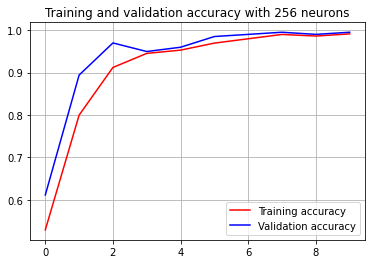

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy with 256 neurons')
plt.legend(loc=0)
plt.grid()
plt.show()

**EVALUATION VIA CONFUSION MATRIX**

[[14  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0]
 [ 0  0 18  0  0  0  0]
 [ 0  0  0  8  0  0  0]
 [ 0  0  0  1 20  0  0]
 [ 0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0 25]]


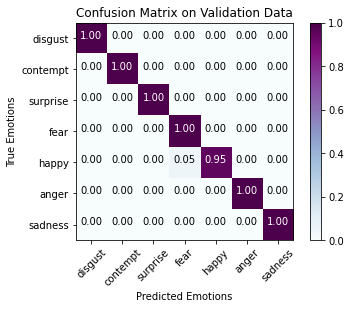

In [33]:
emotion = os.listdir('/content/images/train')
import itertools
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm):
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap="BuPu")
    plt.title('Confusion Matrix on Validation Data')
    plt.colorbar()
    tick_marks = np.arange(len(emotion))
    plt.xticks(tick_marks, emotion,rotation=45)
    plt.yticks(tick_marks, emotion)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Emotions')
    plt.xlabel('Predicted Emotions')
    plt.show()
predictions = model.predict(validation_generator,  4)

y_pred = np.argmax(predictions, axis=1)
plot_confusion_matrix(confusion_matrix(validation_generator.classes, y_pred))

# ***Cross validation***

In [30]:
os.mkdir('/content/folds')
for i in range(0,10):
  os.mkdir('/content/folds/fold'+str(i))
  os.mkdir('/content/folds/fold'+str(i)+'/train')
  os.mkdir('/content/folds/fold'+str(i)+'/test')
  for j in os.listdir('/content/datasets/CK+48'):
    os.mkdir('/content/folds/fold'+str(i)+'/train/'+j)
    os.mkdir('/content/folds/fold'+str(i)+'/test/'+j)

In [ ]:
for i in range(0,10):
  fold_path = '/content/folds/fold' + str(i)
  test_fold = '/content/folds/fold' + str(i) + '/test'
  train_fold = '/content/folds/fold' + str(i) + '/train'
  for j in os.listdir(train_fold):
    emotion_train_fold = train_fold + '/' + j
    emotion_test_fold = test_fold + '/' + j
    emotion_source = '/content/datasets/CK+48/' + j
    length = len(os.listdir(emotion_source))
    initial_size = int(i*length/10)
    final_size = int((i+1)*length/10)
    files = []
    for k in os.listdir(emotion_source):
      path = emotion_source + '/' + k 
      files.append(k)
    testing_set = files[initial_size:final_size]
    training_set = []
    for n in files:
      if n not in testing_set:
        training_set.append(n)
    for filename in training_set:
      src = emotion_source + '/' + filename
      des = emotion_train_fold + '/' + filename
      copyfile(src,des)
    for filename in testing_set:
      src = emotion_source + '/' + filename
      des = emotion_test_fold + '/' + filename
      copyfile(src,des)

In [36]:
sum_acc=0
for i in range(0,10):
  fold_path = '/content/folds/fold' + str(i)
  TRAINING_DIR = train_fold = '/content/folds/fold' + str(i) + '/train'
  train_datagen = ImageDataGenerator(rescale=1./255,
      horizontal_flip=True,
      rotation_range=2,                          
      preprocessing_function=preprocessing
      )
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=50,
                                                    class_mode='categorical',
                                                    target_size=(100,100),
                                                    shuffle=True,
                                                    color_mode='grayscale')

  VALIDATION_DIR = '/content/folds/fold' + str(i) + '/test'
  validation_datagen = ImageDataGenerator(
    rescale=1./255,
      horizontal_flip=True,
      rotation_range=2,
      preprocessing_function=preprocessing
      )
  validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=50,
                                                              class_mode='categorical',
                                                              target_size=(100,100),
                                                              shuffle=True,
                                                    color_mode='grayscale')
  validation_generator.shuffle = False
  validation_generator.index_array = None
  model = CNN_model_with_256_neurons(7)
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
  history = model.fit(train_generator,epochs=10,batch_size=50,shuffle=True)
  test_loss,test_acc=model.evaluate(validation_generator)
  sum_acc=sum_acc+test_acc
avg_acc=sum_acc/10
print(avg_acc)

Found 887 images belonging to 7 classes.
Found 94 images belonging to 7 classes.
Epoch 1/10
18/18 [==============================] - 38s 2s/step - loss: 2.1895 - accuracy: 0.2796
Epoch 2/10
18/18 [==============================] - 33s 2s/step - loss: 1.2351 - accuracy: 0.5829
Epoch 3/10
18/18 [==============================] - 33s 2s/step - loss: 0.6847 - accuracy: 0.7734
Epoch 4/10
18/18 [==============================] - 33s 2s/step - loss: 0.4465 - accuracy: 0.8478
Epoch 5/10
18/18 [==============================] - 33s 2s/step - loss: 0.2910 - accuracy: 0.9076
Epoch 6/10
18/18 [==============================] - 33s 2s/step - loss: 0.2934 - accuracy: 0.9064
Epoch 7/10
18/18 [==============================] - 34s 2s/step - loss: 0.1969 - accuracy: 0.9346
Epoch 8/10
18/18 [==============================] - 33s 2s/step - loss: 0.1125 - accuracy: 0.9628
Epoch 9/10
18/18 [==============================] - 33s 2s/step - loss: 0.0874 - accuracy: 0.9741
Epoch 10/10
2/2 [====================

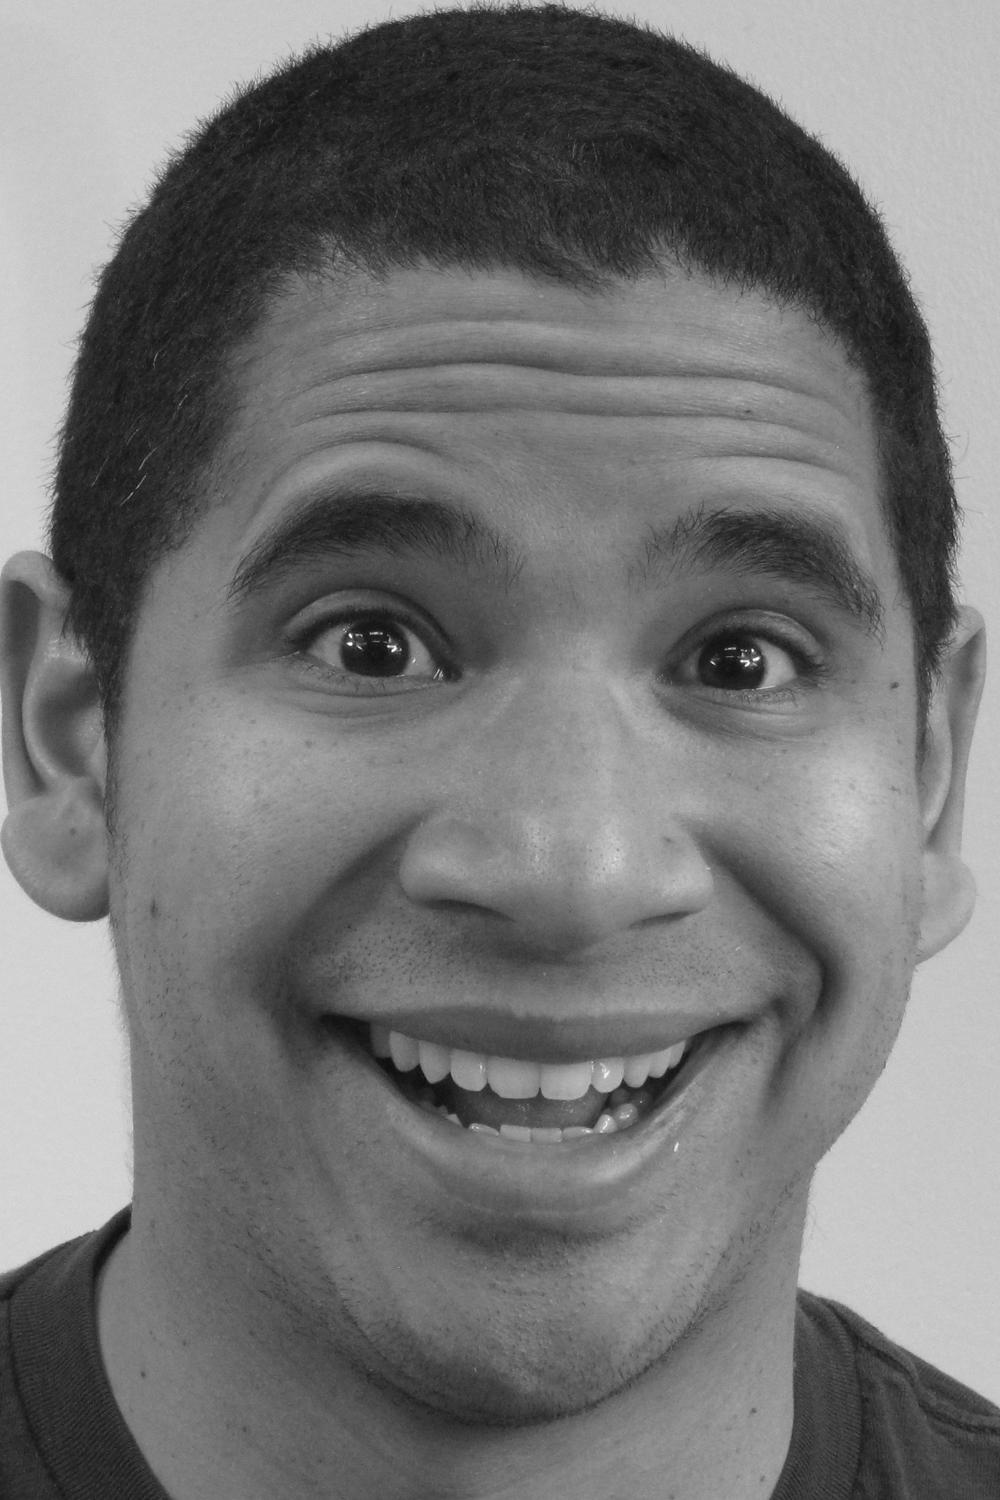

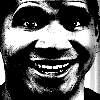

The emotion in the given figure is happy


In [37]:
image = cv2.imread('/content/happily-surprised.jpg',0)
cv2_imshow(image)
image = preprocessing(image)
image = np.array(image)
cv2_imshow(image)
image = image.reshape(1,100,100,1)
print('The emotion in the given figure is ' + emotion[np.argmax(model.predict(image))])